In [45]:
# 필요 라이브러리 다운로드 
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시 설정

# Data prepare

In [46]:
tmp = pd.read_csv("data/클러스터링결과_2030_id_라벨.csv")
tmp_2 = pd.read_csv("data/customer_agg_kmeans_db_knee_9.csv")

In [47]:
tmp['KMeans_DB_KneeLocato_2030'].value_counts()

KMeans_DB_KneeLocato_2030
0    484649
7     39886
5     25694
6     20766
4      9968
1      9777
8      4087
3      3731
2       941
Name: count, dtype: int64

In [48]:
data_ts = pl.scan_csv('data/CUSTOMER_SCORE_금리.csv').filter([
    pl.col('고객ID').is_in(tmp['고객ID'])
]).collect().to_pandas()

KeyboardInterrupt: 

In [ ]:
data_ts

,고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수
0,9996691351,202106,30,남,일반등급,2500000,0,0,0,0,4.55,1,1,231.333333
1,9996689486,202106,30,여,일반등급,17000000,0,0,340000,0,4.55,2,1,2029.666667
2,9996680650,202106,30,여,일반등급,100000,0,0,0,0,4.55,1,1,20.666667
3,9996676637,202106,30,여,일반등급,4900000,0,0,0,0,4.55,1,1,391.333333
4,9996666899,202106,30,남,일반등급,700000,4100000,9800000,0,0,4.55,3,1,815.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16063089,2000399321,202312,30,남,일반등급,0,0,0,0,100000,9.18,1,1,17.991667
16063090,2000393761,202312,30,남,일반등급,0,0,0,0,100000,9.18,1,1,17.991667
16063091,2000380811,202312,30,남,일반등급,0,0,0,0,100000,9.18,1,1,17.991667
16063092,2000379801,202312,20,여,일반등급,0,0,0,0,100000,9.18,1,1,17.991667


In [6]:
data_tmp = data_ts.join(tmp.set_index('고객ID')[['KMeans_DB_KneeLocato_2030']], on='고객ID')

In [7]:
data_tmp

,고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수,KMeans_DB_KneeLocato_2030
0,9996691351,202106,30,남,일반등급,2500000,0,0,0,0,4.55,1,1,231.333333,0
1,9996689486,202106,30,여,일반등급,17000000,0,0,340000,0,4.55,2,1,2029.666667,3
2,9996680650,202106,30,여,일반등급,100000,0,0,0,0,4.55,1,1,20.666667,0
3,9996676637,202106,30,여,일반등급,4900000,0,0,0,0,4.55,1,1,391.333333,0
4,9996666899,202106,30,남,일반등급,700000,4100000,9800000,0,0,4.55,3,1,815.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16063089,2000399321,202312,30,남,일반등급,0,0,0,0,100000,9.18,1,1,17.991667,0
16063090,2000393761,202312,30,남,일반등급,0,0,0,0,100000,9.18,1,1,17.991667,0
16063091,2000380811,202312,30,남,일반등급,0,0,0,0,100000,9.18,1,1,17.991667,0
16063092,2000379801,202312,20,여,일반등급,0,0,0,0,100000,9.18,1,1,17.991667,0


# Analyze - Cluster
- Slope 고려 

In [1]:
from scipy.stats import linregress

def compute_slope(group, col):
    x = group['기준년월']  # 독립 변수 (월)
    y = group[col]   # 종속 변수 (잔액, 거래횟수 등)

    if len(x) > 1:  # 데이터 포인트가 2개 이상일 때만 계산
        slope, _, _, _, _ = linregress(x, y)
        return slope
    else:
        return np.nan  # 데이터가 부족할 경우 NaN 반환

In [2]:
# 고객별 Slope 계산 적용
slope_df = data_tmp.groupby('고객ID').apply(
    lambda g: pd.Series({
        '예금_slope': compute_slope(g, '입출금예금'),
        '기타예금_slope': compute_slope(g, '기타예금'),
        '비이자상품_slope': compute_slope(g, '비이자상품'),
        '카드_slope': compute_slope(g, '카드'),
        '대출_slope': compute_slope(g, '대출')
    })
).reset_index()

# 🔹 결과 출력
print(slope_df)

NameError: name 'data_tmp' is not defined

In [3]:
slope_df

NameError: name 'slope_df' is not defined

In [4]:
data_tmp[data_tmp['고객ID'] == 9996691351]['입출금예금'].plot()

NameError: name 'data_tmp' is not defined

In [5]:
slope_df.to_csv('data/slope.csv')

NameError: name 'slope_df' is not defined

# Cluster_EDA

1. 금융 상품 및 저축 패턴 분석 (대부분 했음)
클러스터별 금융 상품(예금, 적금, 펀드, 외화예금) 가입률 확인
특정 금융 상품 선호도가 높은 그룹과 낮은 그룹 분리
각 클러스터별 어떤 상품을 많이 사용하는지  ----> 해야됨
각 클러스터별 어떤 상품 조합을 많이 사용하는지
1-1. 카드 사용
카드 승인금액을 기준으로 소비 성향이 다른 그룹 구분
카드 사용이 활발한 그룹과 그렇지 않은 그룹의 금융 상품 차이
1-2. 대출 이용 패턴 분석
클러스터별 평균 대출 금액 비교
대출이 많은 그룹이 어떤 금융 상품을 더 선호하는지 확인
2.고객 활동성 종합적 비교
금융 상품 가입이 활발한 고객군 vs 가입이 적은 고객군 구분 (완료)
카드 승인 금액, 대출을 포함한 활동성 분석
3. 고객 특성 분석 (20대 vs 30대 차이)
연령별 금융 상품 가입률 차이
카드 사용 빈도 및 승인 금액 차이
대출 이용률 비교
4. 클러스터별 맞춤 금융 상품을 바탕으로 서비스 기획
고활동 그룹: 투자 상품(펀드, 주식 계좌 개설) 또는 프리미엄 금융 상품 추천
저활동 그룹: 소액 적금, 간편 가입 예금, 입출금 계좌 추천
중간 활동 그룹: 대출 추천(전세자금 대출, 신용대출), 보험 상품 추천


In [4]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)
color='mediumaquamarine'

In [5]:
dat_1 = pd.read_csv('data/상품집계_고객집계.csv') #이걸 메인으로 본다 
#dat_2 = pd.read_csv('data/상품전체_고객집계.csv')
#dat_3 = pd.read_csv('data/상품집계_고객전체.csv')
#dat_4 = pd.read_csv('data/상품전체_고객전체.csv')

In [ ]:
data_tmp = dat_1.drop(columns=['고객ID', '거래기간(개월)', '평균_총점수', '최대_보유상품종류', '연령대', '최대_고객등급',
       'KMeans_DB_KneeLocato_2030', '중분류'])

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler

def kmeans_clustering_2(data, n_clusters=4):
    """
    K-means 클러스터링 수행 - RobustScaler 적용 및 클러스터별 특징 시각화
    """
    
    # 스케일러 적용
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data)
    
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(data_scaled)

    return clusters


In [48]:
tmp = kmeans_clustering_2(data_tmp)

In [75]:
tmp

array([0, 0, 0, ..., 0, 0, 0])

<Axes: ylabel='count'>

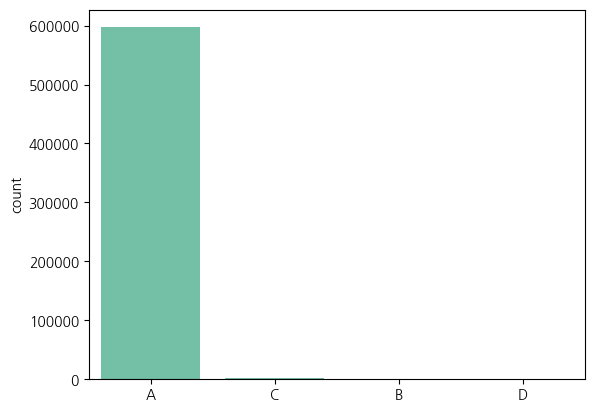

In [80]:
tmp_v = pd.Series(tmp).replace([0, 1, 2, 3], ['A', 'B', 'C', 'D']).value_counts()
sns.barplot(tmp_v, color='mediumaquamarine')

<Axes: xlabel='중분류', ylabel='count'>

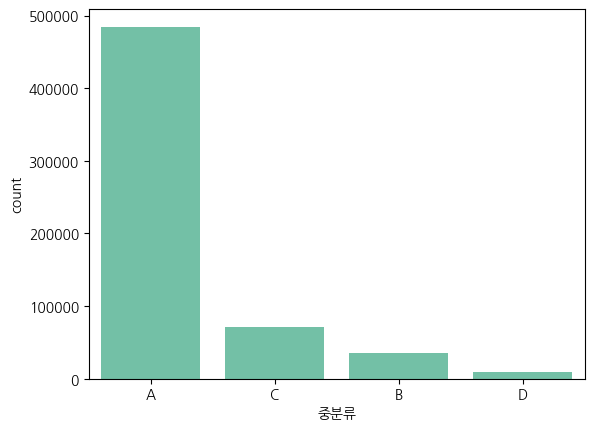

In [81]:
sns.barplot(dat_1['중분류'].value_counts(), color='mediumaquamarine')

In [3]:
dat_1.columns

Index(['고객ID', '평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출금액',
       '거래기간(개월)', '평균_총점수', '최대_보유상품종류', '평균_보유상품종류', '연령대', '최대_고객등급',
       'KMeans_DB_KneeLocato_2030', '중분류'],
      dtype='object')

중분류
A    484649
C     70620
B     35471
D      8759
Name: count, dtype: int64
중분류
A    0.808423
C    0.117798
B    0.059168
D    0.014611
Name: proportion, dtype: float64


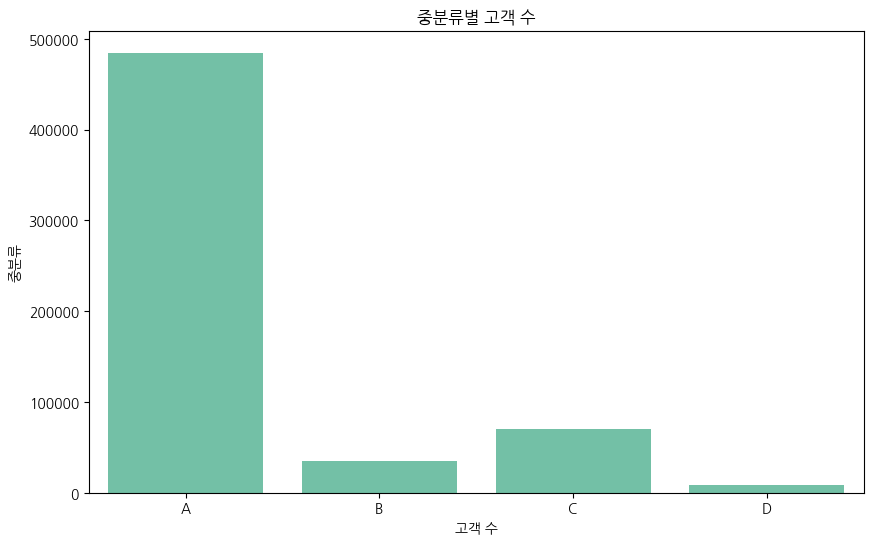

In [4]:
category_counts = dat_1['중분류'].value_counts()
print(category_counts)

category_pcs = dat_1['중분류'].value_counts(normalize=True)
print(category_pcs)

plt.figure(figsize=(10, 6))
sns.countplot(x='중분류', data=dat_1, order=['A', 'B', 'C', 'D'], color=color)
plt.title('중분류별 고객 수')
plt.xlabel('고객 수')
plt.ylabel('중분류')
plt.show()

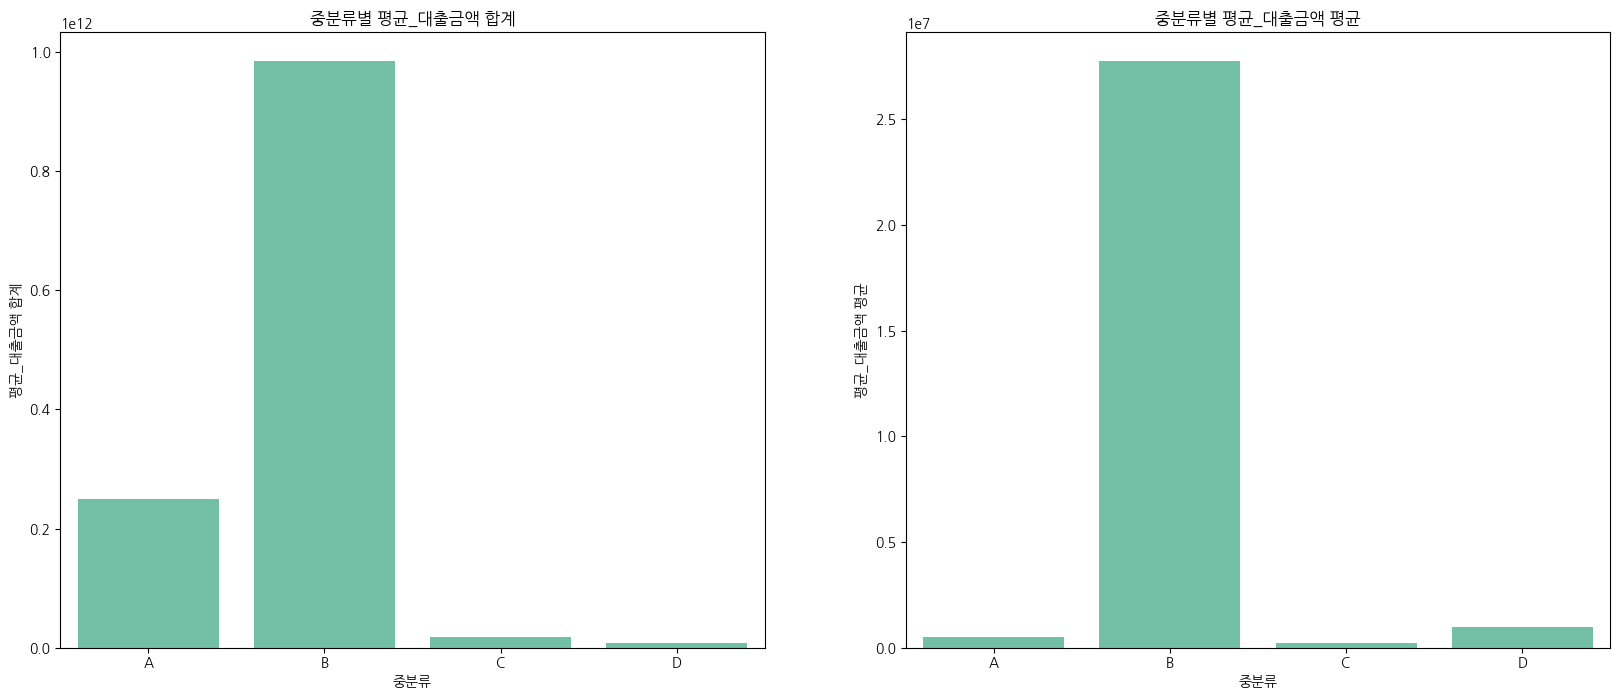

In [5]:
tmp = dat_1.groupby('중분류').agg({
    '평균_대출금액': ['sum', 'mean']
}).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='중분류', y=('평균_대출금액', 'sum'), data=tmp, color=color, ax=axs[0])
sns.barplot(x='중분류', y=('평균_대출금액', 'mean'), data=tmp, color=color, ax=axs[1])
axs[0].set_title('중분류별 평균_대출금액 합계')
axs[1].set_title('중분류별 평균_대출금액 평균')
plt.xlabel('중분류')
axs[0].set_ylabel('평균_대출금액 합계')
axs[1].set_ylabel('평균_대출금액 평균')
plt.show()

In [7]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

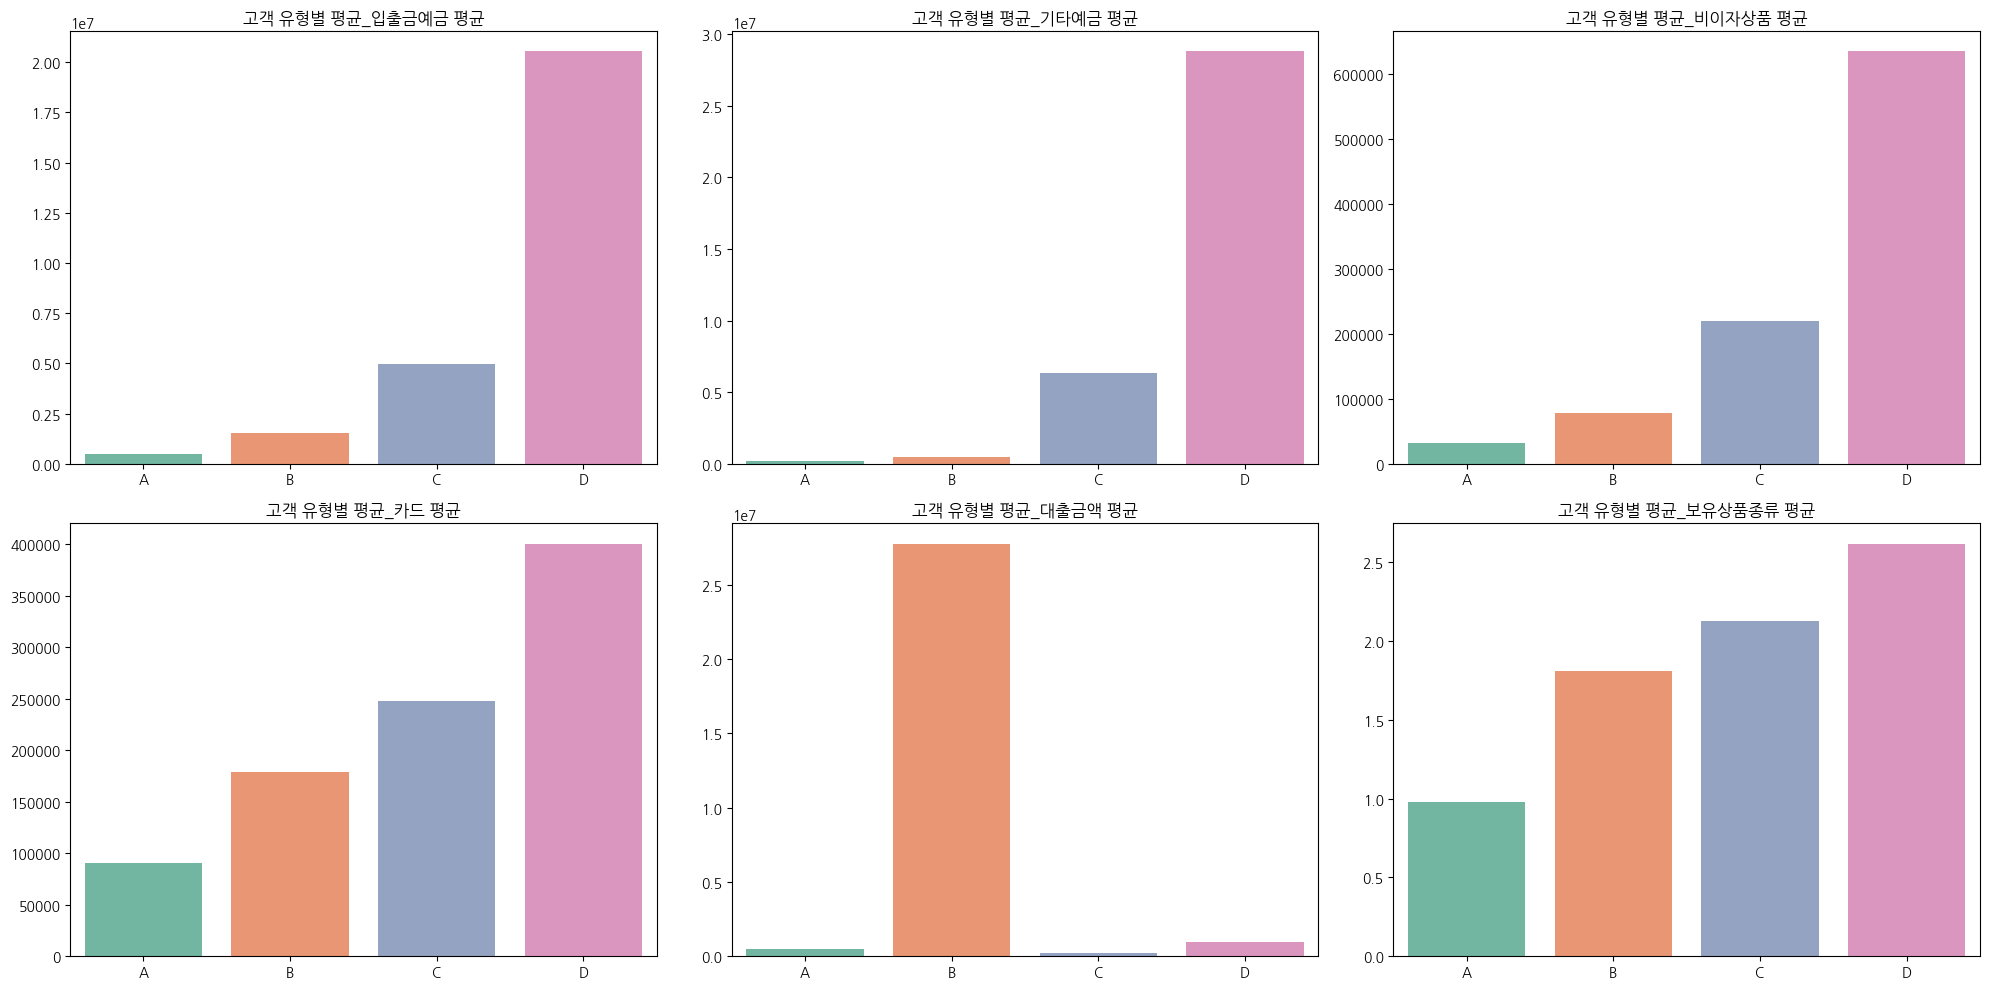

In [12]:
financial_columns = ['평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출금액', '평균_보유상품종류']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, column in enumerate(financial_columns):
    row = i // 3
    col = i % 3
    sns.barplot(y=column, x='중분류', data=dat_1, ci=None, order=['A', 'B', 'C', 'D'], palette='Set2', ax=axs[row, col]) # 자동으로 평균으로 계산하는듯
    axs[row, col].set_title(f'고객 유형별 {column} 평균')
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('') #.set_xlabel('고객 유형')

plt.tight_layout()
plt.show()

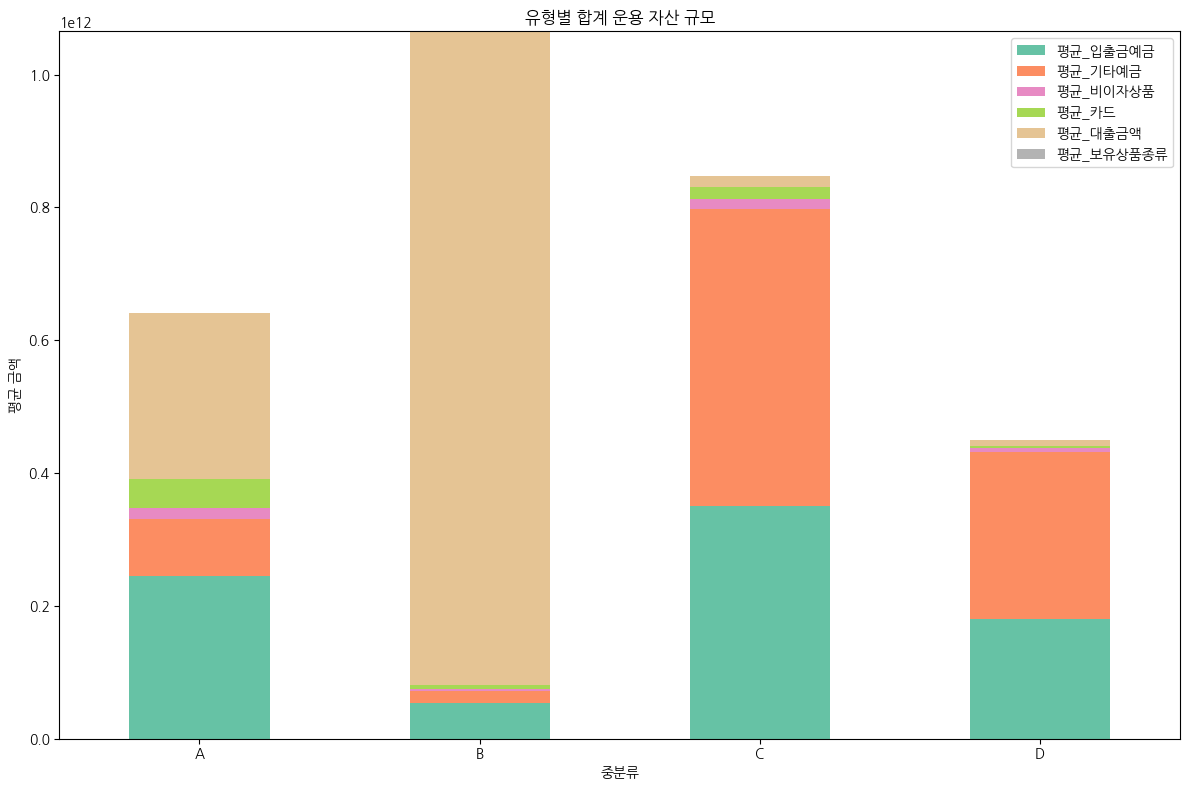

In [33]:
# '중분류' 열의 고유 값 및 원하는 순서 정의
categories = ['A', 'B', 'C', 'D']

# 각 '중분류'별 금융 상품 평균 금액 계산 및 인덱스 재정렬
grouped_data = dat_1.groupby('중분류')[financial_columns].sum().reindex(categories)

# stacked bar 그래프 생성
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='Set2')

plt.title('유형별 합계 운용 자산 규모')
plt.xlabel('중분류')
plt.ylabel('평균 금액')
plt.xticks(rotation=0)  # x축 레이블 회전 제거
plt.tight_layout()
plt.show()

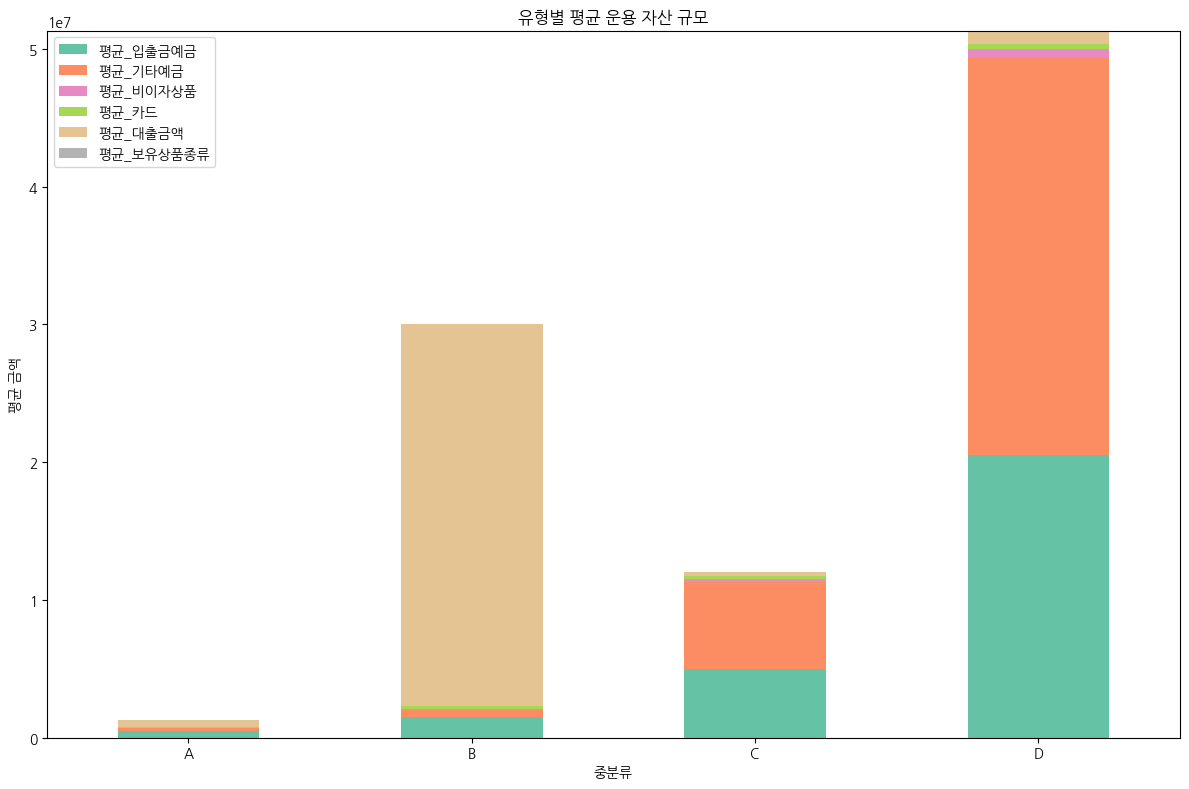

In [32]:
# 각 '중분류'별 금융 상품 평균 금액 계산 및 인덱스 재정렬
grouped_data_2 = dat_1.groupby('중분류')[financial_columns].mean().reindex(categories)

# stacked bar 그래프 생성
grouped_data_2.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='Set2')

plt.title('유형별 평균 운용 자산 규모')
plt.xlabel('중분류')
plt.ylabel('평균 금액')
plt.xticks(rotation=0)  # x축 레이블 회전 제거
plt.tight_layout()
plt.show()

### 그룹 B 분석 - 대출이 많은 비중
- 그룹 B가 대출이 가장 많으며, 활발한 모습을 보인다. 이들의 특징이 무엇일까?
- 그룹 B는 전체적으로 대출 '만' 하러 iM뱅크를 사용하는 것으로 보인다. 
    - 다른 금융상품과의 유사성 또는 뚜렸한 선형적 관계가 관측되지 않음 (pairplot 참조)

In [10]:
asset_totals

,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출금액
중분류,,,,,
A,5.055698e+05,1.785405e+05,32236.943830,90197.478762,5.157633e+05
B,1.537164e+06,4.817684e+05,77600.212694,178897.298491,2.775243e+07
C,4.972895e+06,6.322605e+06,218971.410267,247907.978799,2.444942e+05
D,2.053698e+07,2.881104e+07,634392.219266,400212.465433,9.585929e+05


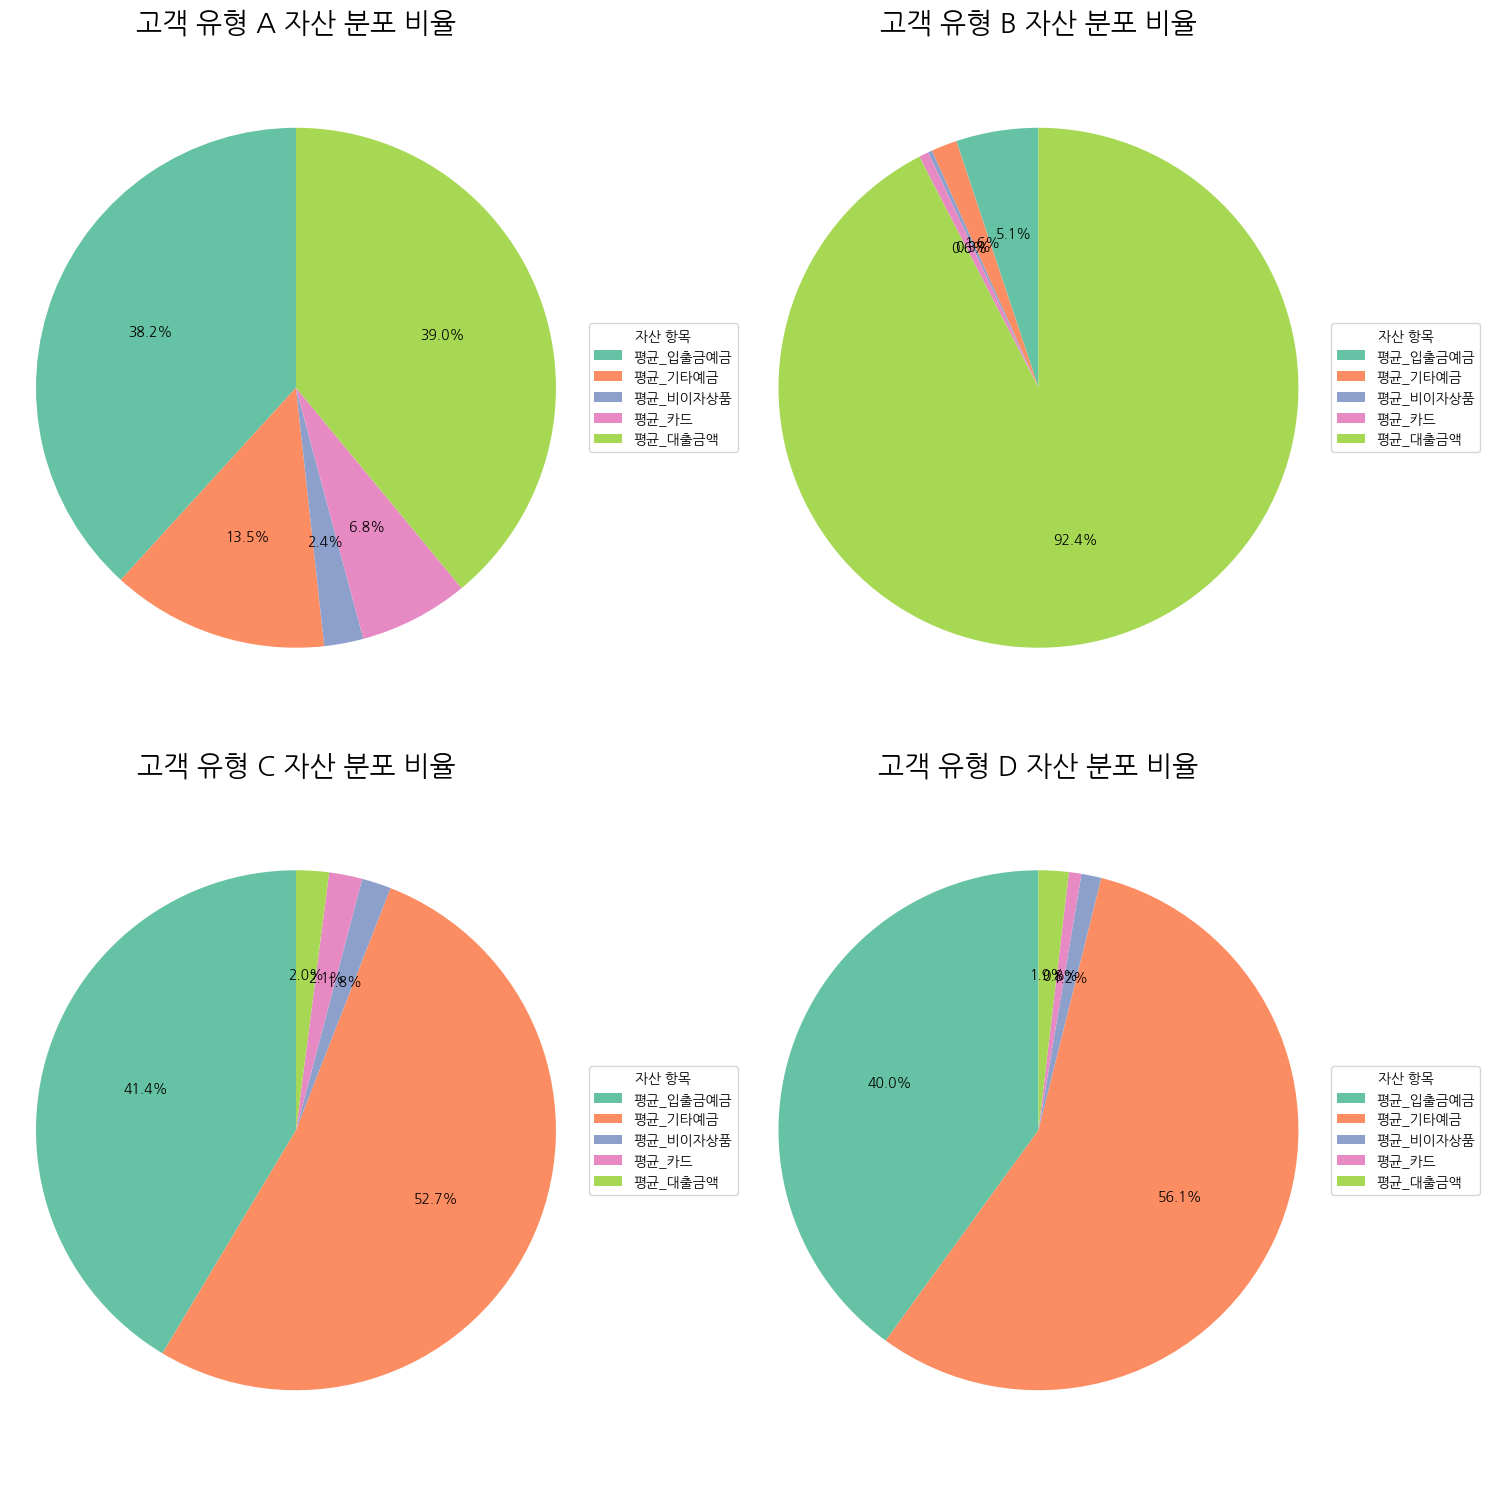

In [29]:
# 자산 관련 열 선택
asset_columns = ['평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출금액']

# 각 자산의 총합 계산
asset_totals = dat_1.groupby('중분류')[asset_columns].mean()

# 각 행을 하나의 파이 차트로 그리시오.
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, (index, row) in enumerate(asset_totals.iterrows()):
    row_idx = i // 2
    col_idx = i % 2
    wedges, texts, autotexts = axs[row_idx, col_idx].pie(row, autopct='%1.1f%%', startangle=90, colors=color_palette)
    axs[row_idx, col_idx].set_title(f'고객 유형 {index} 자산 분포 비율', fontsize = 20)
    axs[row_idx, col_idx].axis('equal')
    axs[row_idx, col_idx].legend(wedges, asset_columns, title='자산 항목', loc='center left', bbox_to_anchor=(1, 0.5))  # 범례 추가
plt.subplots_adjust(hspace=0.000001)
plt.tight_layout()
plt.show()

In [34]:
As = dat_1[dat_1['중분류'] == 'A'][asset_columns]
bs = dat_1[dat_1['중분류'] == 'B'][asset_columns]
cs = dat_1[dat_1['중분류'] == 'C'][asset_columns]
ds = dat_1[dat_1['중분류'] == 'D'][asset_columns]

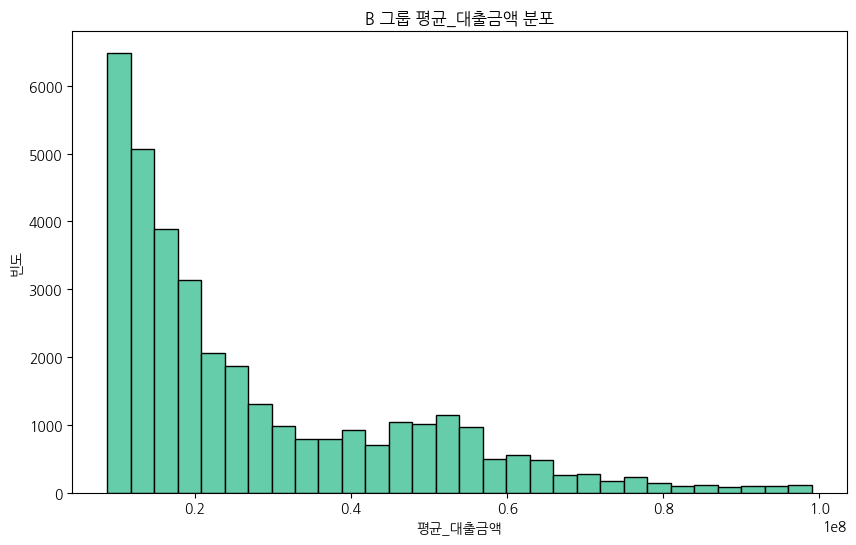

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(bs['평균_대출금액'], bins=30, edgecolor='black', color=color)
plt.title('B 그룹 평균_대출금액 분포')
plt.xlabel('평균_대출금액')
plt.ylabel('빈도')
plt.show()

<Figure size 1000x1000 with 0 Axes>

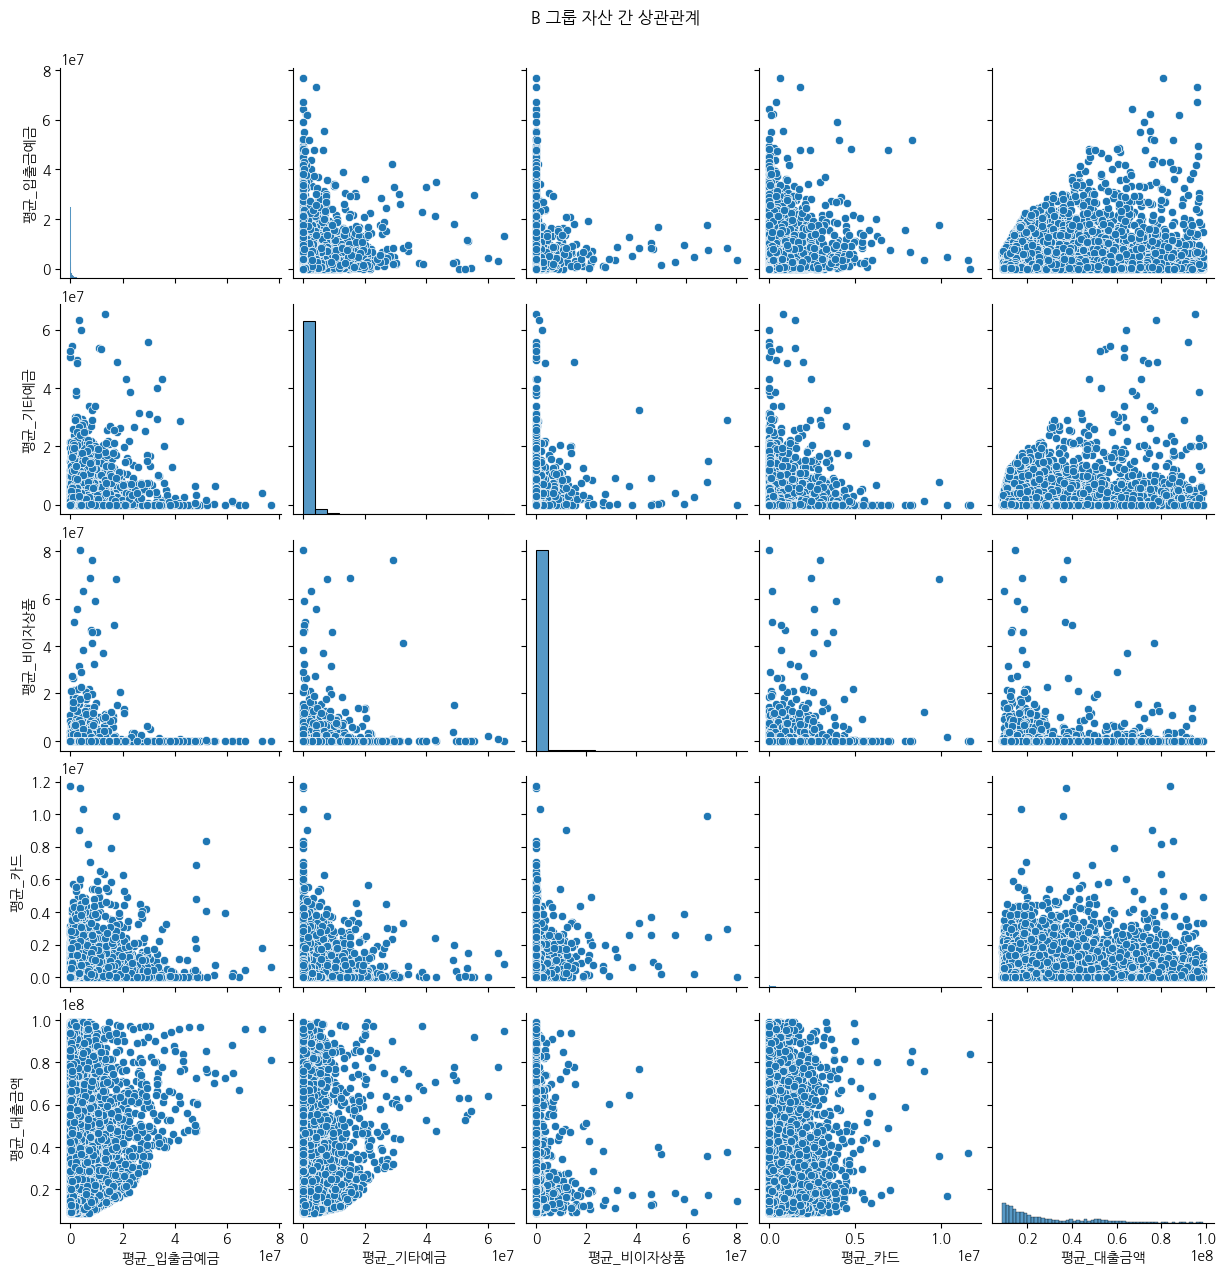

In [31]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.pairplot(bs[asset_columns], palette=['mediumaquamarine'])
plt.suptitle('B 그룹 자산 간 상관관계', y=1.02)
plt.show()

<Figure size 1000x1000 with 0 Axes>

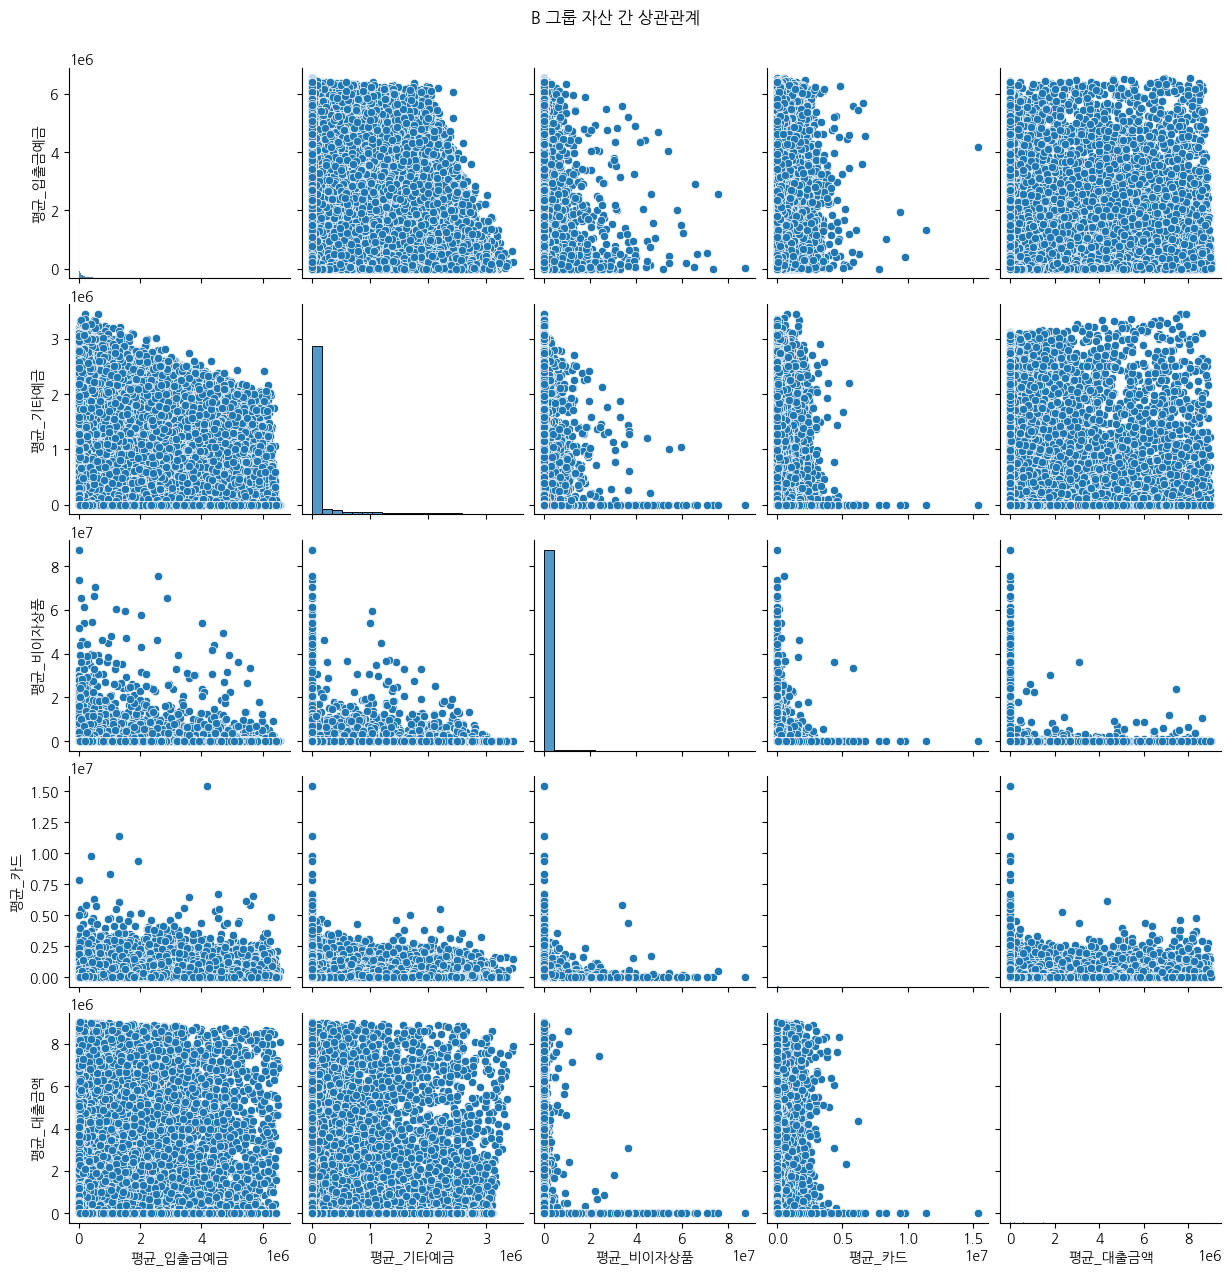

In [35]:

plt.figure(figsize=(10, 10))
sns.pairplot(As[asset_columns], palette=['mediumaquamarine'])
plt.suptitle('A 그룹 자산 간 상관관계', y=1.02)
plt.show()

<Figure size 1000x1000 with 0 Axes>

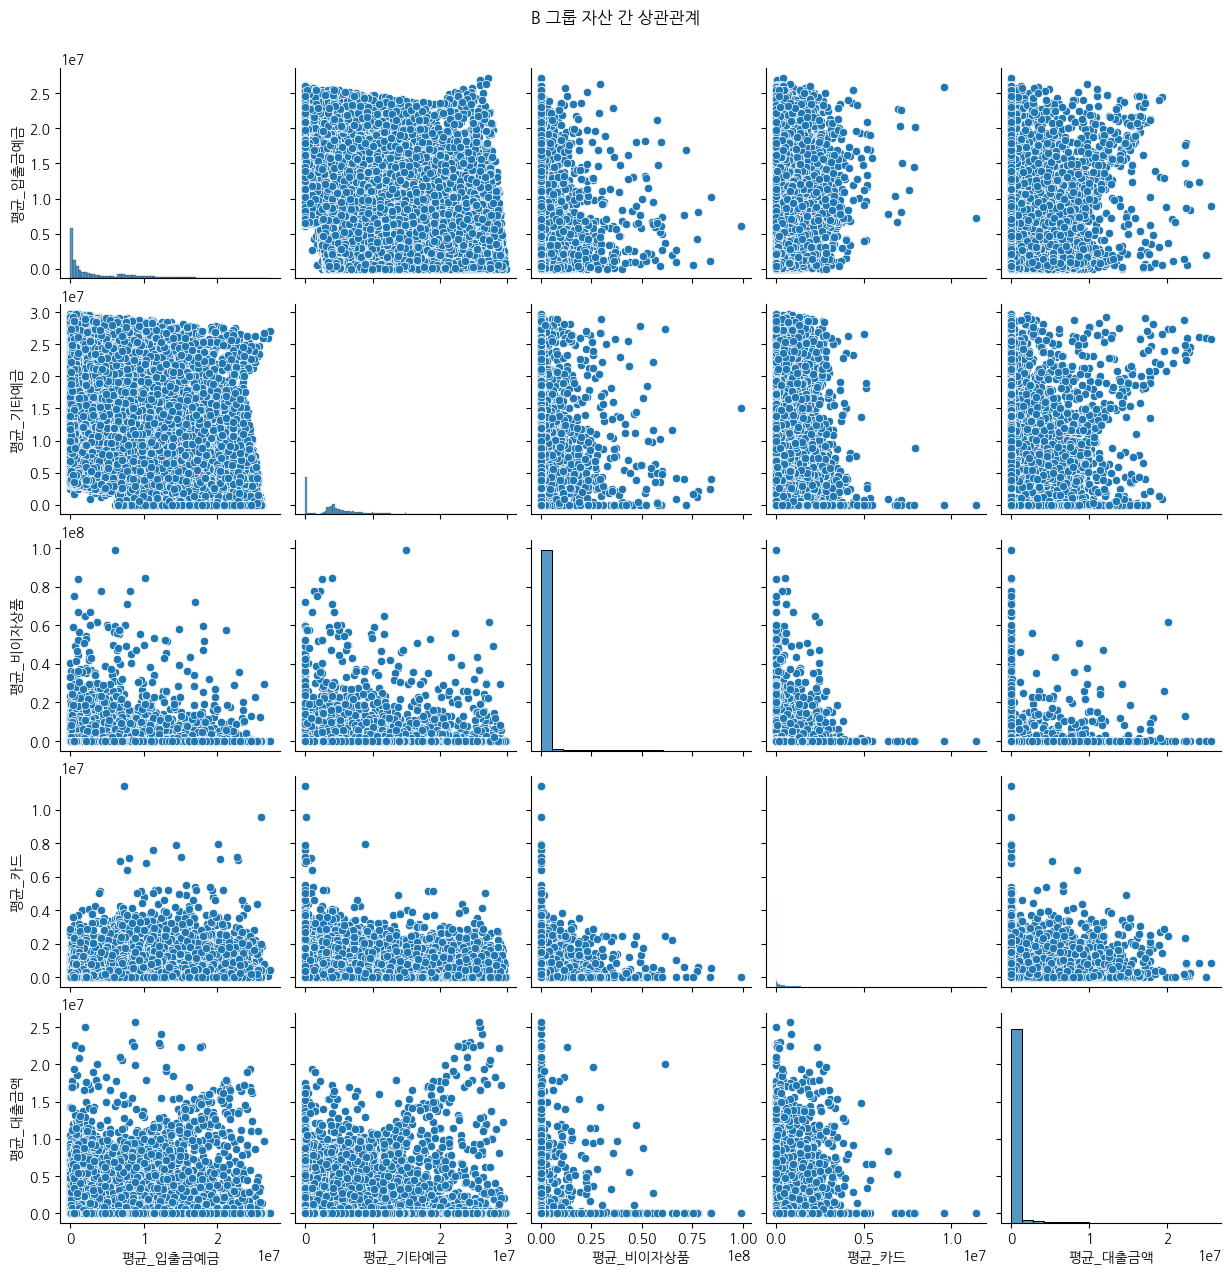

In [36]:

plt.figure(figsize=(10, 10))
sns.pairplot(cs[asset_columns], palette=['mediumaquamarine'])
plt.suptitle('C 그룹 자산 간 상관관계', y=1.02)
plt.show()

<Figure size 1000x1000 with 0 Axes>

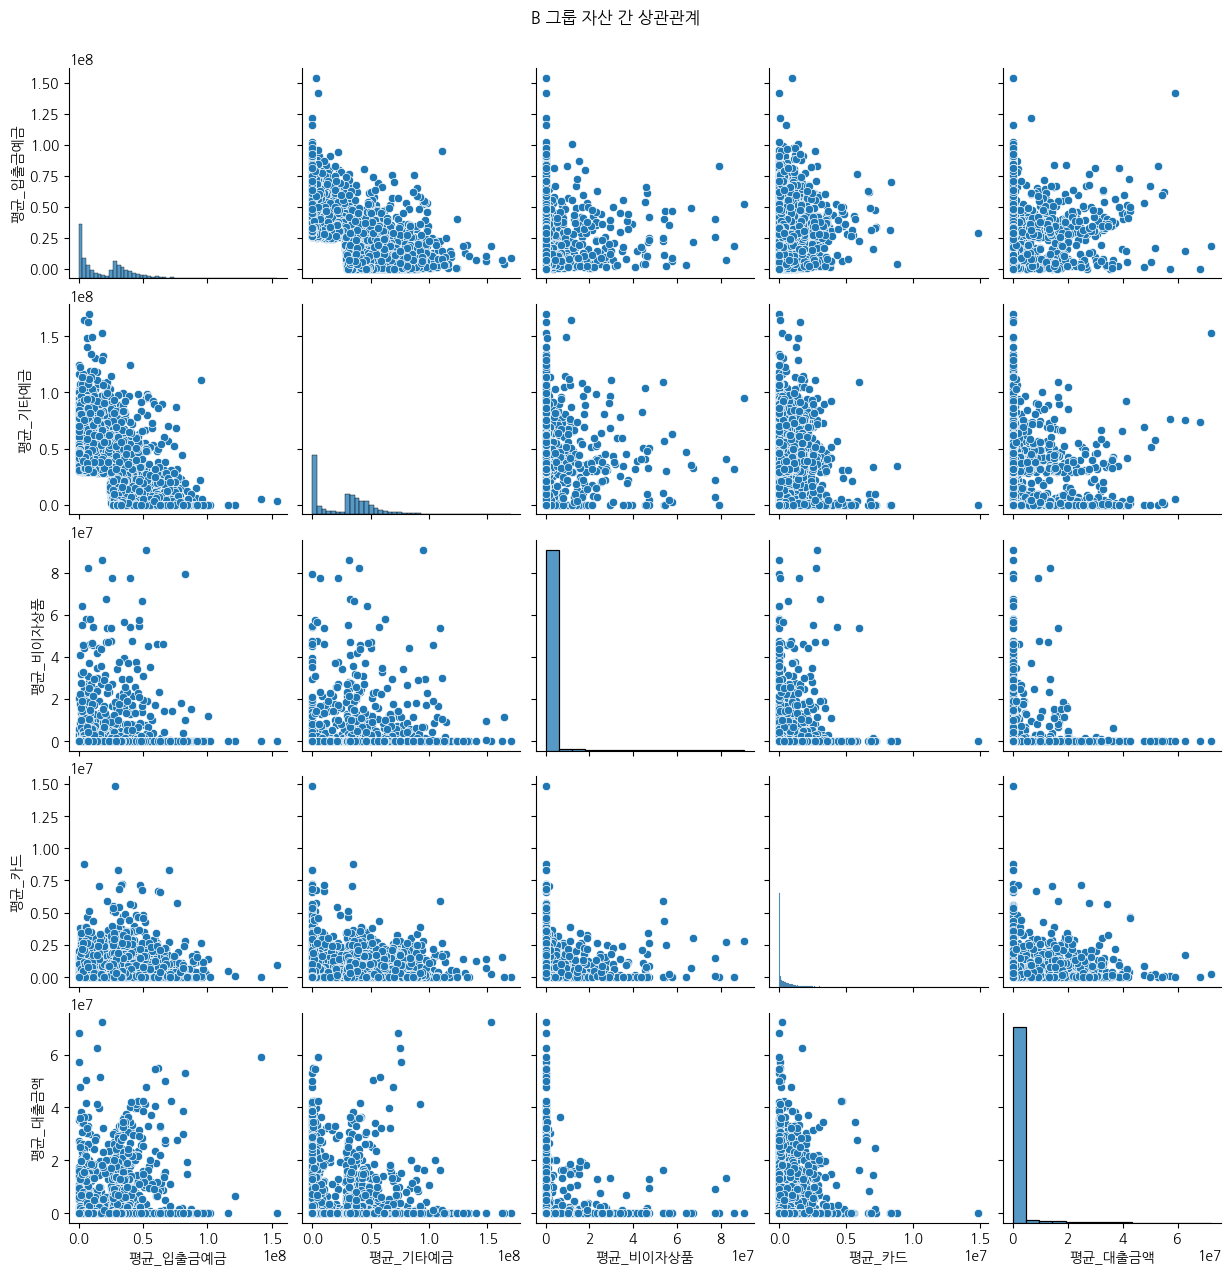

In [37]:

plt.figure(figsize=(10, 10))
sns.pairplot(ds[asset_columns], palette=['mediumaquamarine'])
plt.suptitle('D 그룹 자산 간 상관관계', y=1.02)
plt.show()

In [40]:
# 너무 오래 걸린다
# sns.pairplot(dat_1, hue="중분류", diag_kind="hist")

# Slope Overview

In [ ]:
# pl to csv에서 발생한 인덱스 칼럼 삭제

slope_df = slope_df.drop(columns='Unnamed: 0')

In [ ]:
dat_1.join(slope_df, on = '', how = 'left')